# Text classification and hyperparameter optimization

In [1]:
import numpy as np
import pandas as pd
import altair as alt
alt.renderers.enable('mimetype')
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC

<br>

## 1: The dataset and EDA
<hr>

We will be developing an SMS spam classification system using Kaggle's [SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset). The prediction problem here is predicting whether a given text message is spam or not spam.  


In [2]:
sms_df = pd.read_csv("../downloads/spam.csv", encoding="latin-1")
sms_df = sms_df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})

In [3]:
sms_df.head()

,target,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 1.1 Data splitting 


We will split `sms_df` into train (80%) and test splits (20%) with `random_state=123`. 

In [4]:
train, test = train_test_split(sms_df, test_size=0.2, random_state=123)
print(f"The dimension of train data is {train.shape}.\nThe dimension of test data is {test.shape}")

The dimension of train data is (4457, 2).
The dimension of test data is (1115, 2)


<br><br>

### 1.2 Simple EDA 


Since we are dealing with text data we will carry out some simple EDA like distribution of target and average length of text, and shortest and longest SMS to get a sense of the data.



In [5]:
label_dist = train['target'].value_counts()
label_dist

ham     3843
spam     614
Name: target, dtype: int64

In [6]:
avg_length = train["sms"].apply(len).mean()
avg_length

80.28427193179269

In [7]:
train["length"] = train["sms"].apply(len)
shortest_len = train["length"].min()
longest_len = train["length"].max()
print(f"Shortest message is {shortest_len} characters and the longest message is {longest_len} characters long.")

Shortest message is 2 characters and the longest message is 790 characters long.


In [8]:
train.query("length == @shortest_len")["sms"]

5357    Ok
3049    Ok
1924    Ok
4496    Ok
Name: sms, dtype: object

In [9]:
list(train.query("length == @longest_len")['sms'])[0]

"The last thing i ever wanted to do was hurt you. And i didn't think it would have. You'd laugh, be embarassed, delete the tag and keep going. But as far as i knew, it wasn't even up. The fact that you even felt like i would do it to hurt you shows you really don't know me at all. It was messy wednesday, but it wasn't bad. The problem i have with it is you HAVE the time to clean it, but you choose not to. You skype, you take pictures, you sleep, you want to go out. I don't mind a few things here and there, but when you don't make the bed, when you throw laundry on top of it, when i can't have a friend in the house because i'm embarassed that there's underwear and bras strewn on the bed, pillows on the floor, that's something else. You used to be good about at least making the bed."

<br><br>

### 1.3 Encoding 



We would use bag of words (CountVectorizer) to encode the `sms` column. One-hot encoding applies to categorical column with repeated values, and we won't be able to apply it here because with a slight change in our value (adding or removing a character), our trained model might have not seen the new value, and therefore, is not able to predict our target.

<br><br>

## 2: Exploring `CountVectorizer` 
<hr>

We will be encoding the text data using [sklearn's `CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). We will explore different options of `CountVectorizer`. 

### 2.1 `CountVectorizer` with default parameters
We will:  
- Create `X_train`, `y_train`, `X_test`, `y_test`. 
- Create a `CountVectorizer` with default hyperparameters and transform the training data. 


> Note that unlike other transformers where we pass a `pd.DataFram`, we pass a `pandas.Series` object or a 1-D array to `CountVectorizer`. 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(sms_df["sms"], sms_df["target"], test_size=0.2, random_state=123)

In [11]:
countvec = CountVectorizer()
sms_transformed = countvec.fit_transform(X_train)
sms_transformed

<4457x7682 sparse matrix of type '<class 'numpy.int64'>'
	with 59329 stored elements in Compressed Sparse Row format>

Dimensianlity of the transfromed data is (4457, 7682).

<br><br>

### 2.2 `stop_words='english'`

We create a `CountVectorizer` with `stop_words='english'` and transform the training data. We will see that dimensionality decreases. Stop words are common words used in a language that do not help with classification models. When we are setting our model to not include them, we will end up with features not including these words, and therefore, our column count decreases. See below for stop words examples. 

In [12]:
countvec_eng = CountVectorizer(stop_words="english")
sms_transformed_eng = countvec_eng.fit_transform(X_train)
sms_transformed_eng

<4457x7419 sparse matrix of type '<class 'numpy.int64'>'
	with 34984 stored elements in Compressed Sparse Row format>

In [13]:
countvec_eng.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

<br><br>

### 2.3 `max_features` 

Now we pass the following two arguments to `CountVectorizer` and transform the training data again. 
    - `max_features=1000`
    - `stop_words=english` 
The column count will now be 1000 since we have specifically set the maximum number of features to 1000.

In [14]:
count_vec_eng_max = CountVectorizer(stop_words="english", max_features=1000)
sms_eng_max = count_vec_eng_max.fit_transform(X_train)
sms_eng_max

<4457x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 23679 stored elements in Compressed Sparse Row format>

<br><br>

### 2.4 Visualizing the transformed data

We will:
- Examine some features (words) created by `CountVectorizer` in 2.3. 
- Visualize the transformed data from 2.3 as a pandas dataframe by only including the columns below as an example. 
    - 'free'
    - 'love'
    - 'prize'
    - 'urgent'
- Pick a row of choice from this dataframe, which has a non-zero value for any of the above features, and print the corresponding text message.

In [15]:
count_vec_eng_max.get_feature_names_out()[:100]

array(['00', '000', '03', '04', '06', '0800', '08000839402',
       '08000930705', '0870', '10', '100', '1000', '10p', '11', '12',
       '12hrs', '150', '150p', '150ppm', '16', '18', '1st', '20', '200',
       '2000', '2003', '20p', '25', '250', '25p', '2day', '2lands', '2nd',
       '2nite', '30', '3030', '350', '4u', '50', '500', '5000', '750',
       '800', '8007', '86688', '87066', '87077', '8th', '900', 'able',
       'abt', 'ac', 'accept', 'account', 'actually', 'address', 'admirer',
       'aft', 'afternoon', 'age', 'ago', 'ah', 'aight', 'al', 'alex',
       'alright', 'amp', 'angry', 'ans', 'answer', 'anytime', 'apply',
       'appreciate', 'ard', 'area', 'asap', 'ask', 'askd', 'asked',
       'asking', 'ass', 'attempt', 'auction', 'available', 'await',
       'awaiting', 'awake', 'award', 'awarded', 'away', 'awesome', 'b4',
       'babe', 'baby', 'bad', 'balance', 'bank', 'bath', 'bathe', 'bcoz'],
      dtype=object)

In [16]:
"urgent" in count_vec_eng_max.get_feature_names_out()

True

In [17]:
pd.DataFrame(sms_eng_max.toarray(), columns=list(count_vec_eng_max.get_feature_names_out()))[["free", "love", "prize", "urgent"]]

,free,love,prize,urgent
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,1,1
4,0,0,0,0
...,...,...,...,...
4452,0,0,0,0
4453,1,0,0,0
4454,0,0,0,0
4455,0,0,0,0


In [18]:
row_3 = pd.DataFrame(sms_eng_max.toarray(), columns=list(count_vec_eng_max.get_feature_names_out())).iloc[3]
" ".join(row_3[row_3 == 1].index.tolist()).upper()

'03 06 10 150PPM 2000 2ND ASAP ATTEMPT BONUS BOX CALLER MOBILE NUMBER PRIZE REACH URGENT WON'

<br><br>

### 2.5 Discussion
 

- With lower number of features we are likely to underfit, as opposed to including all features where we are likely to overfit. For lower number of features we do not have enough word features in order to use for prediction, and will therefore, have bias towards predicting the same thing (average value) over and over again. In other words, we will be ignoring a lot of words in our test and deployment data if we only use selective few from our train data.

In [19]:
ex_msg = "I love how much you are enjoying this notebook."

In [20]:
count_vec_eng_max.transform(pd.Series(ex_msg))

<1x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Row format>

- From the above we can see that we have only one non-zero value stored in our sparse matrix.
- Unknown words are ignored when we transform our data using CountVectorizer simply because no corresponding column would exist from the fit stage in order to store the count of the new word.

<br><br>

## 3: Model building 
<hr>

### 3.1 `DummyClassifier`

Now it's time to build models. We will start with a baseline model. Mean CV score for dummy classifier is **0.86** meaning that if we just go with the most common target value, we will get a 86% accuracy. This is mainly due to the target values not having a balanced distribution. In other words there are a lot more ham examples than spam, and if we predicted ham as our prediction for everything, 86% of the time we would have been correct.


In [21]:
cross_validate(DummyClassifier(), X_train, y_train)["test_score"].mean()

0.862239233390205

<br><br>

### 3.2 `SVC` with default parameters

Now we build a pipeline for feature extraction using `CountVectorizer` with `stop_words='english'` and `SVC` with default hyperparameters.  
The mean cross validation score is 0.977 which is a big improvement over the dummy classifier CV score.

In [22]:
pipe = make_pipeline(CountVectorizer(stop_words="english"), SVC())

cross_validate(pipe, X_train, y_train)["test_score"].mean()

0.9771126813727712

<br><br>

## 4: Hyperparameter optimization 
<hr>

Checking different hyperparameter values and picking the one with lowest cross-validation error is so common that `scikit-learn` has some [built-in methods](https://scikit-learn.org/stable/modules/grid_search.html) to do it for you. In this exercise, we will explore two such methods:

1. [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 
2. [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

### 4.1 Optimizing `C` for SVM RBF

- We will first carry out hyperparameter search over `C` by sweeping the hyperparameter through the values $10^{-3}, \ldots, 10^{-1}, 1, \ldots, 10^{3}$ using [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and 10-fold cross-validation. 
- Then we plot training and cross-validation curves with `C` on the x-axis and scores on the y-axis. 

A few tips about `GridSearchCV`: 

- Setting `n_jobs=-1` should speed things up (by using our multi-core processor).
- Similar to `cross_validate`, we can pass `return_train_score=True` to your `GridSearchCV` object.
- By default, after carrying out the search, `GridSearchCV` also refits a model with the entire training set with the best hyperparameter values. 

In [23]:
param_grid = {"svc__C": 10.0 ** np.arange(-3, 4)}

In [24]:
pipe = make_pipeline(CountVectorizer(), SVC())
grid = GridSearchCV(
    pipe, param_grid=param_grid, cv=10, n_jobs=-1, return_train_score=True
)
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             return_train_score=True)

In [25]:
results = pd.DataFrame(grid.cv_results_)[["param_svc__C", "mean_test_score", "mean_train_score"]]
results

,param_svc__C,mean_test_score,mean_train_score
0,0.001,0.862240,0.862239
1,0.01,0.862240,0.862239
2,0.1,0.865380,0.866527
3,1.0,0.979803,0.995139
4,10.0,0.981823,0.999776
5,100.0,0.981599,1.000000
6,1000.0,0.981599,1.000000


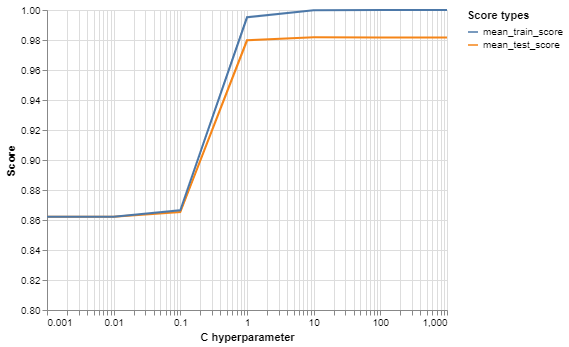

In [26]:
melted_result = results.melt(id_vars="param_svc__C")
alt.Chart(melted_result).mark_line().encode(
    x=alt.X("param_svc__C", scale=alt.Scale(type="log"), title="C hyperparameter"),
    y=alt.Y("value", scale=alt.Scale(domain=(0.8, 1)), title="Score"),
    color=alt.Color("variable", sort="-color", title="Score types"),
)

In [27]:
grid.best_score_

0.9818229455333298

In [28]:
grid.best_params_

{'svc__C': 10.0}

The best validation score after doing grid search is **0.982** which is a 0.5% improvement over the default SVC parameters.

<br><br>

### 4.2 Jointly optimizing `C` and `gamma`

We will now optimize `C` hyperparameter along with `gamma`. 


In [29]:
param_grid = {
    "svc__C": 10.0 ** np.arange(-3,4),
    "svc__gamma": 10.0 ** np.arange(-3,4),
}

In [30]:
pipe_gamma_C = make_pipeline(CountVectorizer(), SVC())
grid_gamma_C = GridSearchCV(
    pipe_gamma_C,
    param_grid,
    n_jobs=-1,
    return_train_score=True,
)
grid_gamma_C.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'svc__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             return_train_score=True)

In [31]:
opt_results = pd.DataFrame(grid_gamma_C.cv_results_)[
    ["param_svc__gamma", "param_svc__C", "mean_test_score"]
]
opt_results.head()

,param_svc__gamma,param_svc__C,mean_test_score
0,0.001,0.001,0.862239
1,0.01,0.001,0.862239
2,0.1,0.001,0.862239
3,1.0,0.001,0.862239
4,10.0,0.001,0.862239


In [32]:
grid_gamma_C.best_params_

{'svc__C': 100.0, 'svc__gamma': 0.01}

In [33]:
grid_gamma_C.best_score_

0.9840671286859628

While optimizing both gamma and C I got a different C value (100) which in combination with the new gamma of 0.01 slightly improved my score to **0.984**. This does not say that this C score gives me the best score if applied alone. What it means is that in combination with gamma=0.01 this C value gives the best score in my grid search.

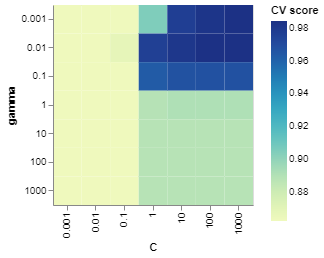

In [34]:
alt.Chart(opt_results).mark_rect().encode(
    x=alt.X("param_svc__C:O", title="C"),
    y=alt.Y("param_svc__gamma:O", title="gamma"),
    color=alt.Color("mean_test_score:Q", title="CV score")
).properties(
    width=200,
    height=200
)

<br><br>

### 4.3 Optimizing `C` and `gamma` of SVM RBF and `binary` and `max_features` of `CountVectorizer` jointly with `RandomizedSearchCV`

Next, I will jointly optimize hyperparameters of `SVC` as well as `CountVectorizer` using `RandomizedSearchCV`, which, as its name implies, tries random hyperparameter configurations instead of performing an exhaustive grid search.   
1. We see  minor improvement in score when applying random search. The best score and parameters are shown below.  
2. One of the situations that RandomSearchCV would give us huge advantage is when we have one or two hyperparameters that are more important that others. In contrast with GridSearch we can define distributions for our hyperparameter to reflect this importance.
3. The other benefit of RandomSearchCV is that it allows defining a distribution to randomly pick the values from in contrast to GridSearchCV which only accepts a list of values.
 

In [35]:
from scipy.stats import expon, lognorm, loguniform, randint, uniform
uniform(0.1, 1e4)

In [36]:
from scipy.stats import loguniform, randint, uniform

pipe = make_pipeline(CountVectorizer(), SVC())
param_distributions = {
    "countvectorizer__binary": [True, False],
    "countvectorizer__max_features": randint(50, 5000),
    "svc__gamma": loguniform(1e-2, 1e3),
    "svc__C": uniform(1e-1, 1e3),
}

random_search = RandomizedSearchCV(pipe, param_distributions, n_iter=100, n_jobs=-1, random_state=123)

In [37]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer()),
                                             ('svc', SVC())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'countvectorizer__binary': [True,
                                                                    False],
                                        'countvectorizer__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000221C748B340>,
                                        'svc__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000221C97502B0>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000221CB7F6610>},
                   random_state=123)

In [38]:
random_search.best_params_

{'countvectorizer__binary': True,
 'countvectorizer__max_features': 3345,
 'svc__C': 214.11191490834625,
 'svc__gamma': 0.03366893122619186}

In [39]:
random_search.best_score_

0.9858626121705344

<br><br>

### 4.4: More sophisticated hyperparameter tuning

There are all sorts of software packages that make hyperparameter tuning with `scikit-learn` even more automated. For example:

- [hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn)
- [auto-sklearn](https://github.com/automl/auto-sklearn)
- [SigOptSearchCV](https://sigopt.com/docs/overview/scikit_learn)

For non-`scikit-learn` packages there are many other options to play around with. This list isn't meant to be exhaustive.

- [TPOT](https://github.com/rhiever/tpot)
- [hyperopt](https://github.com/hyperopt/hyperopt)
- [hyperband](https://github.com/zygmuntz/hyperband)
- [SMAC](http://www.cs.ubc.ca/labs/beta/Projects/SMAC/)
- [MOE](https://github.com/Yelp/MOE)
- [pybo](https://github.com/mwhoffman/pybo)
- [spearmint](https://github.com/HIPS/Spearmint)
- [BayesOpt](https://github.com/rmcantin/bayesopt)
- [Amazon SageMaker](https://aws.amazon.com/sagemaker/)

<br><br>

## 5: Test results
<hr>

Now that we have done extensive hyperparameter search, it's time to assess our model. 

### 5.1 Assessing the model

We will evaluate the optimized model from 4.3 on the test set, and also try the best model on a couple of spam and ham (non-spam) text messages from my own inbox.
 

In [40]:
optimized_pipe = make_pipeline(
    CountVectorizer(binary=True, max_features=3345), SVC(gamma=0.03, C=214)
)

optimized_pipe.fit(X_train, y_train)
optimized_pipe.score(X_test, y_test)

0.9829596412556054

The test accuracy is **0.983** which is very close to our best cross_validation score of **0.986** from the above hyperparameter optimization.

In [41]:
text = pd.Series(
    [
        "Hello, I have a profitable deal to share with you, 50% for you if you can help me close the deal. Please reply if you are interested to know more and how you can help me.",
        "𝖸𝗈𝗎 𝗐𝖾𝗋𝖾 𝗋𝖾𝖼𝖾𝗇𝗍𝗅𝗒 𝖺𝗌𝗄𝖾𝖽 𝗍𝗈 𝗍𝖺𝗄𝖾 𝖺𝗇 𝖺𝖼𝗍𝗂𝗈𝗇 𝗈𝗇 𝗒𝗈𝗎𝗋 𝖺𝖼𝖼𝗈𝗎𝗇𝗍 𝖺𝗇𝖽 𝗂𝗍 𝗅𝗈𝗈𝗄𝗌 𝗅𝗂𝗄𝖾 𝗐𝖾 𝖽𝗂𝖽𝗇'𝗍 𝗋𝖾𝖼𝖾𝗂𝗏𝖾 𝖺 𝗋𝖾𝗊𝗎𝖾𝗌𝗍𝖾𝖽 𝗋𝖾𝗌𝗉𝗈𝗇𝗌𝖾. 𝖶𝖾 𝗁𝖺𝗏𝖾 𝖿𝗈𝗎𝗇𝖽 𝗌𝗎𝗌𝗉𝗂𝖼𝗂𝗈𝗎𝗌 𝖺𝖼𝗍𝗂𝗏𝗂𝗍𝗒 𝗈𝗇 𝗍𝗁𝖾 𝖼𝗋𝖾𝖽𝗂𝗍 𝖼𝖺𝗋𝖽 𝗅𝗂𝗇𝗄𝖾𝖽 𝗍𝗈 𝗒𝗈𝗎𝗋 𝖯𝖺𝗒𝖯𝖺𝗅 𝖺𝖼𝖼𝗈𝗎𝗇𝗍. 𝖸𝗈𝗎 𝗆𝗎𝗌𝗍 𝖼𝗈𝗇𝖿𝗂𝗋𝗆 𝗒𝗈𝗎𝗋 𝗂𝖽𝖾𝗇𝗍𝗂𝗍𝗒 𝗍𝗈 𝖼𝗈𝗇𝖿𝗂𝗋𝗆 𝗍𝗁𝖺𝗍 𝗒𝗈𝗎 𝖺𝗋𝖾 𝗍𝗁𝖾 𝗈𝗐𝗇𝖾𝗋 𝗈𝖿 𝗍𝗁𝖾 𝖼𝗋𝖾𝖽𝗂𝗍 𝖼𝖺𝗋𝖽.",
    ]
)
optimized_pipe.predict(text)

array(['ham', 'ham'], dtype=object)

### 5.2 Conclusion

As shown in the example above from my inbox the two spam emails have been classified as ham. This shows that the model is not able to predict well in the wild. The main reason this is happening is the very low number of sample data (less than 10_000) and a very small percentage of spam emails in the train data set. In order for this model to generalize better we will need to collect more observations (in the order of millions) and a more balanced target distribution.